# Extremes, Outliers, and GOATs

This is one of the Jupyter notebooks I used in my preparation of *Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*.

The book is scheduled to be published by University of Chicago Press in 2023.
If you would like to get infrequent email announcements about the book, please
[sign up for my mailing list](http://eepurl.com/h0nfbX).

Before you read these notebooks, please keep in mind:

* There is some explanatory text in the notebooks, but some of the examples will not make sense until you have read the corresponding chapter in the book.

* While preparing these notebooks, I made some changes to improve the readability of the code. There might be small differences between what appears in the book and what you get when you run the code.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/notebooks/lognormal.ipynb).

In [61]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [62]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

Technical note: The following function is an example of a computational method I often use to fit a distribution to data.

Conventional methods are generally based on moment-matching or computing maximum-likelihood estimators for the parameters.

But often the question we care about is whether there is a distribution in a particular family that is a good match for a given empirical distribution. The best way to answer that question is to plot the CDFs of the data and the model and compare them visually to see where they agree or disagree.

If that's the evaluation metric, then the right thing to optimize is the distance between the distributions, averaged in some way over the range of the quantities.

There are several ways you could do that. The option I use here is to write an error function that takes hypothetical set of parameters and

1. Makes an object that represents a distribution with those parameters.

2. Chooses a range of percentiles and finds the corresponding quantiles in the data.

3. Evaluates the model distribution at those quantiles, and

4. Computes the vertical distance between the resulting percentiles and the target percentiles.

Then I use `least_squares` to find the parameters that minimize the sum of the squares of these distances.

In [64]:
from empiricaldist import Cdf
from scipy.optimize import least_squares
from scipy.stats import norm


def fit_normal(series):
    """Find the model that minimizes the errors in percentiles."""

    def error_func(params, series):
        mu, sigma = params
        cdf = Cdf.from_seq(series)
        qs = series.quantile([0.1, 0.3, 0.5, 0.7, 0.9])
        error = cdf(qs) - norm.cdf(qs, mu, sigma)
        return error

    params = series.mean(), series.std()
    res = least_squares(error_func, x0=params, args=(series,), xtol=1e3)
    assert res.success
    mu, sigma = res.x
    return norm(mu, sigma)

In [65]:
from scipy.stats import binom


def normal_error_bounds(dist, n, qs, alpha=0.95):
    """Find the bounds on a normal CDF analytically."""
    # find the correct probabilities
    ps = dist.cdf(qs)

    # find the upper and lower percentiles of
    # a binomial distribution
    p_low = (1 - alpha) / 2
    p_high = 1 - p_low

    low = binom.ppf(p_low, n, ps) / n
    low[ps == 1] = 1
    high = binom.ppf(p_high, n, ps) / n
    return low, high

In [66]:
from gaussian import make_cdf


def make_plot(series, model_label=None, plot_bounds=True, qs=None, **options):
    """Plot a CDF with a Gaussian model.
    
    series: data
    model_label: string label for the model
    plot_bounds: boolean, whether to plot the expected upper bound
    qs: values where the error bounds should be evaluated (optional)
    options: passed to plt.plot
    """
    cdf = make_cdf(series)
    dist = fit_normal(series)
    p = 1 - (1 / len(series))
    upper = dist.ppf(p)

    if plot_bounds:
        plt.plot(upper, p * 100, "+", color="black", ms=12)

    n = len(series)
    if qs is None:
        q_max = max(cdf.qs.max(), upper)
        qs = np.linspace(cdf.qs.min(), q_max)

    low, high = normal_error_bounds(dist, n, qs)
    plt.fill_between(
        qs, low * 100, high * 100, lw=1, color="gray", alpha=0.3, label=model_label
    )

    cdf.plot(**options)

In Chapter 1 we saw that many measurements in the natural world follow a Gaussian distribution, and I posited an explanation: if we add up many random factors, the distribution of the sum tends to be Gaussian.

The average height in the United States is about 170 cm.
The tallest person ever was 272 cm, which is certainly tall, but it is only 60% greater than the mean.
And in all likelihood, no one will ever be substantially taller.

In [67]:
# https://en.wikipedia.org/wiki/List_of_tallest_people

272 / 170 * 100

160.0

The heaviest person ever reliably measured was almost eight times the current average in the United States.

In [68]:
# https://en.wikipedia.org/wiki/List_of_heaviest_people

653 / 82

7.963414634146342

Suppose we start with an absolute beginner at chess, named A.
You could easily find a more experienced player -- call them B -- who would beat A 90% of the time.
And it would not be hard to find a player C who could beat B 90% of the time; in fact, C would be pretty close to average.

Then you could find a player D who could beat C 90% of the time and a player E who could beat D about as often.

In a Gaussian distribution, that's about all you would get. If A is a rank beginner and C is average, E would be one of the best, and it would be hard to find someone substantially better.
But the distribution of chess skill is lognormal and it extends farther to the right than a Gaussian.
In fact, we can find a player F who beats E, a player G who beats F, and a player H who beats G, at each step more than 90% of the time.
And the world champion in this distribution would still beat H almost 90% of the time.

In [69]:
a = np.arange(100, 3400, 400)
pd.Series(a, index=list("ABCDEFGHI"))

A     100
B     500
C     900
D    1300
E    1700
F    2100
G    2500
H    2900
I    3300
dtype: int64

In [70]:
def elo_prob(diff):
    return 1 - 1 / (1 + np.power(10, diff / 400))

In [71]:
elo_prob(400), elo_prob(300), 

(0.9090909090909091, 0.8490204427886767)

## The Exception

I'll use data from the Behavioral Risk Factor Surveillance System
(BRFSS), which is an annual survey run by the U.S. Centers for Disease Control and Prevention (CDC).

The 2020 dataset includes information about demographics, health, and health risks
from a large, representative sample of adults in the United States: a total of 195,055 men and 205,903 women.
Among the data are the self-reported weights of the respondents, recorded in kilograms.

In [72]:
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/brfss_sample.hdf")

In [73]:
brfss = pd.read_hdf("brfss_sample.hdf", "brfss")

In [74]:
male = brfss["_SEX"] == 1
female = brfss["_SEX"] == 2
male.sum(), female.sum()

(196055, 205903)

In [75]:
weight = brfss["WTKG3"] + np.random.normal(0, 1, size=len(brfss))
weight.describe()

count    365435.000000
mean         82.025558
std          21.153435
min          21.061554
25%          67.199892
50%          79.483232
75%          92.775075
max         289.686997
Name: WTKG3, dtype: float64

The following figure shows the distribution of these weights, represented using cumulative distribution functions (CDFs).
The lighter lines show Gaussian models that best fit the data;
the crosses at the top show the locations of the largest weights we expect to find in samples this size from a Gaussian distribution.

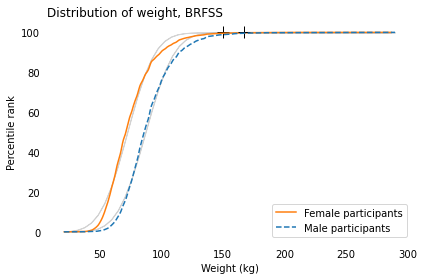

In [76]:
make_plot(weight[female], label="Female participants", color="C1")
make_plot(weight[male], label="Male participants", style="--")

decorate(
    xlabel="Weight (kg)",
    ylabel="Percentile rank",
    title="Distribution of weight, BRFSS",
)

If these distributions were Gaussian, the heaviest woman in the sample would be about 150 kg, and the heaviest man would be 167 kg.
In fact, the heaviest woman is 286 kg and the heaviest man is 290 kg.

In [77]:
def upper_bound(series):
    """Compute the expected maximum value from a Gaussian model
    
    Use the sample to fit a Gaussian model and compute the largest
    value we expect from a sample that size.
    
    series: sample
    
    returns: float
    """
    dist = fit_normal(series)
    p = 1 - (1 / len(series))
    upper = dist.ppf(p)
    return upper

In [78]:
upper_bound(weight[female]), upper_bound(weight[male])

(149.94520956032576, 167.30677493324202)

In [79]:
np.max(weight[female]), np.max(weight[male])

(286.4292088274667, 289.68699690382215)

In [80]:
def xlabels(labels):
    """Place labels on the x-axis on a log scale.
    
    labels: sequence of numbers
    """
    ticks = np.log10(labels)
    plt.xticks(ticks, labels)


labels = [30, 50, 100, 150, 200, 250]

The following figure shows the distributions of the logarithms of weight along with Gaussian models that best fit them.

At the top of the figure, the labels indicate the logarithms.
At the bottom, the labels indicate the weights themselves.
Notice that the logarithms are equally spaced, but the weights are not.

The vertical dotted lines show the correspondence between the weights and their logarithms for the three examples I just mentioned: 50 kg, 100 kg, and 150 kg.

In [81]:
np.log10(50), np.log10(150)

(1.6989700043360187, 2.1760912590556813)

In [82]:
def two_scale(sample1, sample2, label1, label2, xlabel1, xlabel2):
    """Plot two distributions and label the top and bottom.
    
    The sequence of operations is a little tricky.
    """
    # find the range of qs to use for both distributions
    low = min(sample1.min(), sample2.min())
    high = max(sample1.max(), sample2.max())
    qs = np.linspace(low, high, 100)

    # plot the first distribution
    make_plot(sample1, qs=qs, label=label1, color="C1")
    h1, l1 = plt.gca().get_legend_handles_labels()
    plt.xlabel(xlabel1)
    plt.title("Distribution of weight, log scale")
    xlabels(labels)

    # plot the second distribution
    plt.twiny()
    make_plot(sample2, qs=qs, label=label2, style="--")
    h2, l2 = plt.gca().get_legend_handles_labels()
    plt.legend(h1 + h2, l1 + l2)

    # label the axes
    plt.ylabel("Percentile rank")
    plt.xlabel(xlabel2)
    plt.tight_layout()

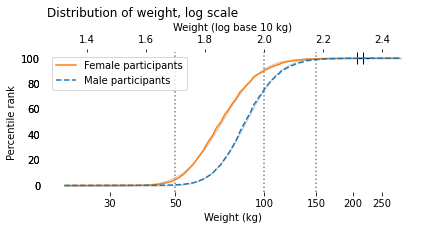

In [83]:
plt.figure(figsize=(6, 3.3))
for x in np.log10([50, 100, 150]):
    plt.axvline(x, color="gray", ls=":")

log_weight_male = np.log10(weight[male])
log_weight_female = np.log10(weight[female])

two_scale(
    log_weight_female,
    log_weight_male,
    "Female participants",
    "Male participants",
    "Weight (kg)",
    "Weight (log base 10 kg)",
)

## Birth Weights are Gaussian

To explore the distribution of birth weight, I'll use data from the National Survey of Family Growth (NSFG), which is run by the CDC, the same people we have to thank for the BRFSS.

Between 2015 and 2017, the NSFG collected data from a representative sample of women in the United States.
Among other information, the survey records the birth weights of their children.
Excluding babies who were born pre-term, I selected weights for 3430 male and 3379 female babies.
The following figure shows the distributions of these birth weights along with Gaussian curves that best fit them.

In [84]:
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/nsfg_sample.hdf5")

In [85]:
nsfg = pd.read_hdf('nsfg_sample.hdf5', 'nsfg')
nsfg.shape

(9553, 13)

In [86]:
live = nsfg["outcome"] == 1
live.sum()

6810

In [87]:
single = nsfg["nbrnaliv"] == 1
single.sum()

6648

In [88]:
fullterm = (nsfg["prglngth"] >= 37) & (nsfg["prglngth"] < 42)
fullterm.sum()

5702

In [89]:
(live & fullterm).sum()

5676

In [90]:
pounds = nsfg["birthwgt_lb1"]
ounces = nsfg["birthwgt_oz1"]

In [91]:
pounds_clean = pounds.replace([98, 99], np.nan)
ounces_clean = ounces.replace([98, 99], np.nan)

birth_weight = (pounds_clean + ounces_clean / 16) * 454

In [92]:
male = nsfg["babysex1"] == 1
male.sum()

3430

In [93]:
female = nsfg["babysex1"] == 2
female.sum()

3379

In [94]:
birth_weight_male = birth_weight[fullterm & male] / 1000
birth_weight_male.describe()

count    2764.000000
mean        3.441670
std         0.505128
min         1.362000
25%         3.149625
50%         3.433375
75%         3.745500
max         5.448000
dtype: float64

In [95]:
birth_weight_female = birth_weight[fullterm & female] / 1000
birth_weight_female.describe()

count    2769.000000
mean        3.317344
std         0.484603
min         0.766125
25%         2.979375
50%         3.319875
75%         3.632000
max         5.419625
dtype: float64

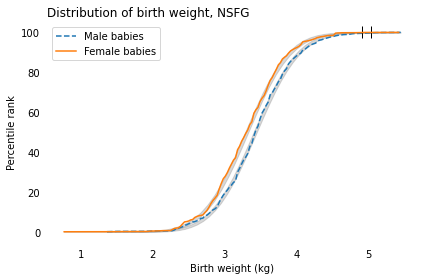

In [96]:
make_plot(birth_weight_male, label="Male babies", style="--")
make_plot(birth_weight_female, label="Female babies", color="C1")

decorate(
    xlabel="Birth weight (kg)",
    ylabel="Percentile rank",
    title="Distribution of birth weight, NSFG",
)

The Gaussian model fits the distribution of birth weights well.
The heaviest babies are a little heavier than we would expect from a Gaussian distribution with this sample size, but the distributions are roughly symmetric, not skewed to the right like the distribution of adult weight.

The following figure shows the logarithms of birth weights compared to a Gaussian distribution.
The data deviate from the model, especially toward the low end.

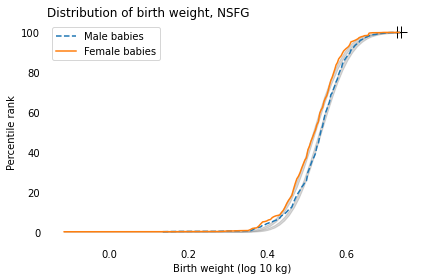

In [97]:
make_plot(np.log10(birth_weight_male), label="Male babies", style="--")
make_plot(np.log10(birth_weight_female), label="Female babies", color="C1")

decorate(
    xlabel="Birth weight (log 10 kg)",
    ylabel="Percentile rank",
    title="Distribution of birth weight, NSFG",
)

## Simulating Weight Gain

I wrote a simulation that starts with the birth weights we saw in the previous section and generates 40 random growth rates, one for each year from birth to age 40.
The growth rates vary from about 20-40%; in other words, each simulated person gains 20-40% of their current weight each year.
The following figure shows the results and a Gaussian model, both on a log scale.

In [99]:
from scipy.stats import norm


def simulate_weights(start, mu=1.3, sigma=0.03):
    """Simulate a simple model of annual weight gain.
    
    start: sequence of starting weights
    mu, sigma: parameters of the distributions of growth factors
    
    returns: simulated adult weights.
    """
    # don't try to hoist this, because the number of rows varies
    np.random.seed(18)
    rows = len(start)
    cols = 40
    rvs = np.random.uniform(-3, 3, size=(rows, cols))

    factors = rvs * sigma + mu
    product = factors.prod(axis=1)
    sim_weight = product * start
    return sim_weight

In [98]:
start = birth_weight_male / 1000  # convert grams to kilograms

In [100]:
mu, sigma = 1.3, 0.03
sim_weight = simulate_weights(start, mu, sigma)
sim_weight.describe()

count    2764.000000
mean      124.106176
std        37.610535
min        37.526516
25%        97.827188
50%       118.558147
75%       144.844003
max       354.605442
dtype: float64

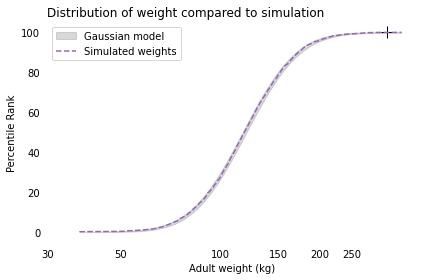

In [101]:
make_plot(
    np.log10(sim_weight),
    model_label="Gaussian model",
    label="Simulated weights",
    color="C4",
    ls="--",
)

decorate(
    xlabel="Adult weight (kg)",
    ylabel="Percentile Rank",
    title="Distribution of weight compared to simulation",
)
xlabels(labels)

The Gaussian model fits the logarithms of the simulated weights, which means that the distribution is lognormal.
This outcome is explained by a corollary of the Central Limit Theorem: if you multiply together a large number of random quantities, the distribution of the product tends to be lognormal.

It might not be obvious that the simulation multiplies random quantities, but that's what happens when we apply successive growth rates.
For example, suppose someone weighs 50 kg at the beginning of a simulated year.
If they gain 20%, their weight at the end of the year would be 50 kg times 120%, which is 60 kg.
If they gain 30% during the next year, their weight at the end would by 60 kg times 130%, which is 78 kg.

In two years, they gained a total of 28 kg, which is 56% of their starting weight.
Where did 56% come from? It's not the sum of 20% and 30%; rather, it comes from the product of 120% and 130%, which is 156%.

So their weight at the end of the simulation is the product of their starting weight and 40 random growth rates.
As a result, the distribution of simulated weights is approximately lognormal.

In [102]:
28 / 50, 1.2 * 1.3

(0.56, 1.56)

By adjusting the range of growth rates, we can tune the simulation to match the data.
The following figure shows the actual distributions from the BRFSS along with the simulation results.

In [103]:
def error_func_sim_weight(params, start, log_weight):
    """Simulate weights with given parameters and compute differences
    between the results and the actual weights.
    
    params: mu and sigma for the dist of growth rates
    start: sequence of starting weights
    log_weight: sequence of adult weights, log scale
    
    returns: sequence of differences
    """
    print(params)
    sim_weight = simulate_weights(start, *params)
    log_sim_weight = np.log10(sim_weight)

    diff_mean = log_sim_weight.mean() - log_weight.mean()
    diff_std = log_sim_weight.std() - log_weight.std()
    error = diff_mean, diff_std
    return error

Search for the parameters that yield simulated weights that best fit the adult male weights.

In [104]:
params = 1.1, 0.03

error_func_sim_weight(params, start, log_weight_male)

(1.1, 0.03)


(-2.773388608450743, 0.0522087828881688)

In [105]:
data = start, log_weight_male
res = least_squares(error_func_sim_weight, x0=params, args=data, xtol=1e-3)
res.x

[1.1  0.03]
[1.10000002 0.03      ]
[1.1        0.03000001]
[1.27449077 0.02147319]
[1.27449079 0.02147319]
[1.27449077 0.0214732 ]
[1.28922056 0.01840052]
[1.28922058 0.01840052]
[1.28922056 0.01840053]
[1.28931344 0.01823682]
[1.28931346 0.01823682]
[1.28931344 0.01823684]


array([1.28931344, 0.01823682])

In [106]:
sim_weight_male = simulate_weights(start, *res.x)
log_sim_weight_male = np.log10(sim_weight_male)
cdf_log_sim_weight_male = make_cdf(log_sim_weight_male)

Search for the parameters that yield simulated weights that best fit the adult female weights.

In [107]:
start = birth_weight_female / 1000
data = start, log_weight_female
res = least_squares(error_func_sim_weight, x0=params, args=data, xtol=1e-3)

[1.1  0.03]
[1.10000002 0.03      ]
[1.1        0.03000001]
[1.27059272 0.02364102]
[1.27059274 0.02364102]
[1.27059272 0.02364103]
[1.28460523 0.0215002 ]
[1.28460525 0.0215002 ]
[1.28460523 0.02150021]
[1.28468727 0.02142869]
[1.28468729 0.02142869]
[1.28468727 0.02142871]


In [108]:
sim_weight_female = simulate_weights(start, *res.x)
log_sim_weight_female = np.log10(sim_weight_female)
cdf_log_sim_weight_female = make_cdf(log_sim_weight_female)

In [109]:
cdf_log_weight_male = make_cdf(log_weight_male)
cdf_log_weight_female = make_cdf(log_weight_female)

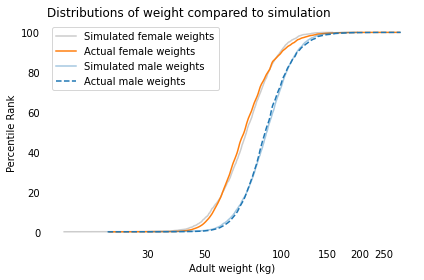

In [110]:
cdf_log_sim_weight_female.plot(
    label="Simulated female weights", color="gray", alpha=0.4
)
cdf_log_weight_female.plot(label="Actual female weights", color="C1")

cdf_log_sim_weight_male.plot(label="Simulated male weights", color="C0", alpha=0.4)
cdf_log_weight_male.plot(label="Actual male weights", color="C0", ls="--")

decorate(xlabel="Adult weight (kg)", ylabel="Percentile Rank",    title="Distributions of weight compared to simulation",
)
xlabels(labels)

The results from the simulation are a good match for the actual distributions.

Qualitatively, the biggest difference is that the Gaussian distribution is symmetric, so the tallest people and the shortest are about the same distance from the mean.
In the BRFSS dataset, the average height is 170 cm. The 99th percentile is about 23 cm above the mean and the 1st percentile is about 20 cm below, so that's roughly symmetric.

Taking it to the extremes, the tallest person ever reliably measured was Robert Wadlow, who was 272 cm, which is 102 cm from the mean.
And the shortest adult was Chandra Bahadur Dangi, who was 55 cm, which is 115 cm from the mean.
That's pretty close to symmetric, too.

In [111]:
def test_symmetry(series):
    """See how far the percentiles are from the mean in each direction.
    
    series: sequence of values
    """
    mean = series.mean()
    percentiles = series.quantile([0.01, 0.99])
    print("mean", mean)
    print("percentiles", percentiles.values)
    print("diffs", percentiles.values - mean)

In [112]:
height = brfss["HTM4"]

In [113]:
test_symmetry(height)

mean 170.16244793762374
percentiles [150. 193.]
diffs [-20.16244794  22.83755206]


In [114]:
272 - 170, 55 - 170

(102, -115)

On the other hand, the distribution of weights is not symmetric: the heaviest people are substantially farther from the mean than the lightest.
In the United States, the average weight is about 82 kg.
The heaviest person in the BRFSS dataset is 64 kg above average, but the lightest is only 36 kg below.

Taking it to the extremes, the heaviest person person ever reliably measured was, regrettably, 553 kg heavier than the average.
In order to be the same distance below the mean, the weight of the lightest person would be 471 kg lighter than zero, which is impossible.
So the Gaussian model of weight is not just a bad fit for the data, it produces absurdities.

In [115]:
test_symmetry(weight)

mean 82.02555804201864
percentiles [ 46.16635988 145.67363337]
diffs [-35.85919816  63.64807533]


In [164]:
average = 82
146 - average, 635 - average, average - 553

(64, 553, -471)

In contrast, on a log scale the distribution of weight is close to symmetric.
In the adult weights from the BRFSS, the 99th percentile of the logarithms is 0.26 above the mean and the 1st percentile is 0.24 below the mean.
At the extremes, the log of the heaviest weight is 0.9 above the mean.
In order for the lightest person to be the same distance below the mean, they would have to weigh 10 kg, which might sound impossible, but [the lightest adult](https://en.wikipedia.org/wiki/Luc%C3%ADa_Z%C3%A1rate), according to Guinness World Records, was 2.1 kg at age 17.
I'm not sure how reliable that measurement is, but it is at least close to the minimum we expect based on symmetry of the logarithms.

In [117]:
test_symmetry(np.log10(weight))

mean 1.9004295903025548
percentiles [1.66432563 2.16338095]
diffs [-0.23610396  0.26295136]


In [118]:
mean = np.log10(weight).mean()
mean

1.9004295903025548

In [119]:
np.log10(635) - mean

0.9023441349894208

In [120]:
log_min = mean - (np.log10(635) - mean)
log_min, 10**log_min

(0.998085455313134, 9.956013006853965)

In [121]:
np.log10(2.1) - mean

-1.5782102955686355

## Running Speeds

When I was 42 years old, I could run 200 meters in about 30 seconds (with wind assistance).
But a good high school runner is faster than me.
At a recent meet, the fastest girl at a nearby high school ran 200 meters in about 27 seconds, and the fastest boy ran under 24 seconds.

So, in terms of speed, a fast high school girl is 11% faster than me, a fast high school boy is 12% faster than her;
Nigel Talton, in his prime, was 11% faster than him, Wallace Spearmon was about 8% faster than Talton, and Usain Bolt is about 5% faster than Spearmon.

In [165]:
index = [
    "Me",
    "High School Girl",
    "High School Boy",
    "Talton",
    "Spearmon",
    "Bolt",
]
times = [30, 27, 24, 21.66, 20.1, 19.19]
run_frame = pd.DataFrame(dict(time=times), index=index)
run_frame["speed"] = 200 / run_frame["time"]
run_frame["% change"] = run_frame["speed"].pct_change()
run_frame

,time,speed,% change
Me,30.00,6.666667,NaN
High School Girl,27.00,7.407407,0.111111
High School Boy,24.00,8.333333,0.125000
Talton,21.66,9.233610,0.108033
Spearmon,20.10,9.950249,0.077612
Bolt,19.19,10.422095,0.047421


To demonstrate, I'll use data from the James Joyce Ramble, which is the 10 kilometer race where I ran my previously-mentioned personal record time.
I downloaded the times for the 1,592 finishers and converted them to speeds in kilometers per hour.
The following figure shows the distribution of these speeds on a logarithmic scale, along with a Gaussian model I fit to the data.

In [124]:
download("https://web.archive.org/web/20100429073703/http://coolrunning.com/results/10/ma/Apr25_27thAn_set1.shtml")

In [125]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(open("Apr25_27thAn_set1.shtml"), "html.parser")

In [126]:
speeds = pd.Series([], dtype=float)

table = soup.find("pre")
for line in table.text.split("\n"):
    t = line.split()
    if len(t) in [13, 14]:
        place, place_in_div, div, gun, net, pace = t[0:6]
        place = int(place)
        m, s = [int(x) for x in pace.split(":")]
        secs = m * 60 + s
        kph = 1.61 / secs * 60 * 60
        speeds[place] = kph

len(speeds)

1591

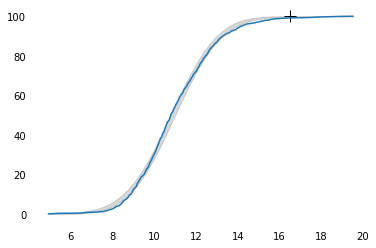

In [127]:
make_plot(speeds)

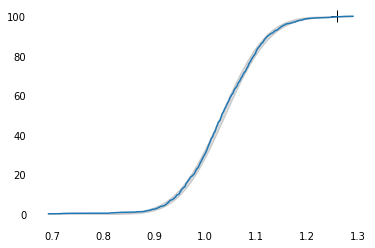

In [128]:
log_speeds = np.log10(speeds)
make_plot(log_speeds)

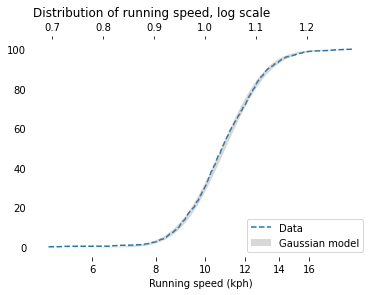

In [129]:
cdf = make_cdf(log_speeds)
cdf.plot(ls="--", label="Data")

h1, l1 = plt.gca().get_legend_handles_labels()
plt.xlabel("Running speed (kph)")

labels = [6, 8, 10, 12, 14, 16]
xlabels(labels)
plt.twiny()

dist = fit_normal(log_speeds)
n = len(log_speeds)
qs = np.linspace(cdf.qs.min(), cdf.qs.max())
low, high = normal_error_bounds(dist, n, qs)
plt.fill_between(
    qs, low * 100, high * 100, lw=0, color="gray", alpha=0.3, label="Gaussian model"
)
h2, l2 = plt.gca().get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc="lower right")

plt.ylabel("Percentile Rank")

ticks = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
plt.xticks(ticks)
#plt.xlabel("Running speed (log base 10 kph)")
plt.title("Distribution of running speed, log scale")
None

I generated five random factors from a Gaussian distribution and multiplied them together.
I adjusted the mean and standard deviation of the Gaussians so that the resulting distribution fit the data; the following figure shows the results.

In [130]:
rows = len(speeds)
cols = 5

np.random.seed(17)
rvs = np.random.normal(size=(rows, cols))

In [131]:
def simulate_speeds(mu, sigma):
    """Generate a sample of running speeds by multiplying factors.
    
    Using the same set of rvs, scale them to the given mean and std.
    
    mu, sigma: parameters of a normal distribution
    """
    factors = rvs * sigma + mu
    performance = pd.Series(factors.prod(axis=1))
    return performance

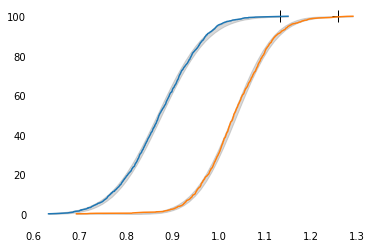

In [132]:
sim_speeds = simulate_speeds(1.5, 0.12)

make_plot(np.log10(sim_speeds))
make_plot(np.log10(speeds))

In [133]:
def error_func_running(params, log_speeds):
    """Run simulation with given params and compute
    differences from the mean and standard deviation of the data.
    
    params: passed to simulation
    log_speeds: data to match
    
    returns: tuple of two errors
    """
    sim_speeds = simulate_speeds(*params)
    log_sim_speeds = np.log10(sim_speeds)

    diff_mean = log_sim_speeds.mean() - log_speeds.mean()
    diff_std = log_sim_speeds.std() - log_speeds.std()
    error = diff_mean, diff_std
    return error

In [134]:
params = 1.1, 0.06
error_func_running(params, log_speeds)

(-0.8328797969155864, -0.018541752148148835)

In [135]:
data = (log_speeds,)
res = least_squares(error_func_running, x0=params, diff_step=0.01, args=data, xtol=1e-3)
assert res.success
res.x

array([1.61636344, 0.11794022])

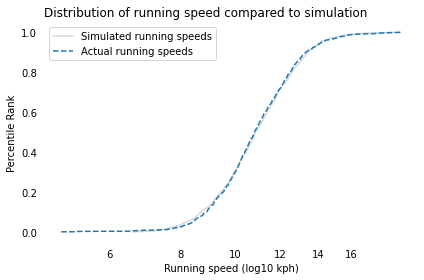

In [136]:
sim_speeds = simulate_speeds(*res.x)

Cdf.from_seq(np.log10(sim_speeds)).plot(
    color="gray", alpha=0.3, label="Simulated running speeds"
)
Cdf.from_seq(np.log10(speeds)).plot(ls="--", label="Actual running speeds")

labels = [6, 8, 10, 12, 14, 16]
xlabels(labels)
decorate(xlabel="Running speed (log10 kph)", ylabel="Percentile Rank",
         title="Distribution of running speed compared to simulation",
)

If there are at least five factors affect running speed, and each person's limit depends on their worst factor, that would explain why the distribution of running speed is lognormal.

## Chess Rankings

I [collected data from Chess.com](https://www.chess.com/leaderboard/live), which is a popular internet chess server that hosts individual games and tournaments for players from all over the world.
Their leader board shows the distribution of Elo ratings for almost six million players who have used their service.
The following figure shows the distribution of these scores on a log scale, along with a lognormal model.

In [137]:
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/chess_elo_ratings.csv")

In [138]:
chess = pd.read_csv("chess_elo_ratings.csv")
chess.head()

,ELO,# PLAYERS
0,100,106342
1,200,219973
2,300,356353
3,400,487607
4,500,570153


In [139]:
chess.tail()

,ELO,# PLAYERS
27,2800,523
28,2900,241
29,3000,86
30,3100,16
31,3200,3


In [140]:
def fit_model_to_cdf(cdf, x0):
    """Find the model that minimizes the errors in percentiles."""

    def error_func(params):
        print(params)
        mu, sigma = params
        ps = np.linspace(0.01, 0.99)
        qs = cdf.inverse(ps)
        # print(qs)
        error = cdf(qs) - norm.cdf(qs, mu, sigma)
        # print(cdf(qs))
        # print(norm.cdf(qs, mu, sigma))
        return error

    res = least_squares(error_func, x0=x0, xtol=1e3)
    assert res.success
    return res.x

In [141]:
def plot_normal_model(dist, n, low, high):
    """Plot the error bounds based on a Gaussian model.
    
    dist: norm object
    n: sample size
    low, high: range of quantities to plot over
    """
    qs = np.linspace(low, high)
    low, high = normal_error_bounds(dist, n, qs)
    plt.fill_between(qs, low * 100, high * 100, lw=0, color="gray", alpha=0.3)

In [142]:
from empiricaldist import Pmf

pmf_chess = Pmf(chess["# PLAYERS"].values, chess["ELO"].values)
N = pmf_chess.normalize()
N

5987898

In [143]:
pmf_chess.mean(), pmf_chess.median()

(814.9840227739351, array(800.))

In [144]:
pmf_chess.make_surv() * 100

100     98.224051
200     94.550425
300     88.599205
400     80.455996
500     70.934241
600     60.640078
700     50.479467
800     40.905774
900     32.580314
1000    25.410620
1100    19.575601
1200    14.800302
1300    11.037880
1400     8.119510
1500     5.890381
1600     4.208121
1700     2.955578
1800     2.031965
1900     1.373220
2000     0.880860
2100     0.554017
2200     0.338733
2300     0.201690
2400     0.117170
2500     0.063511
2600     0.032900
2700     0.014513
2800     0.005778
2900     0.001754
3000     0.000317
3100     0.000050
3200     0.000000
Name: , dtype: float64

In [145]:
pmf_log_chess = pmf_chess.transform(np.log10)
cdf_log_chess = pmf_log_chess.make_cdf()

In [146]:
x0 = pmf_log_chess.mean(), pmf_log_chess.std()
x0

(2.8464761577835587, 0.25442825374680383)

In [147]:
mu, sigma = fit_model_to_cdf(cdf_log_chess, x0)

[2.84647616 0.25442825]
[2.8464762  0.25442825]
[2.84647616 0.25442827]
[2.83678398 0.24883847]
[2.83678403 0.24883847]
[2.83678398 0.24883848]


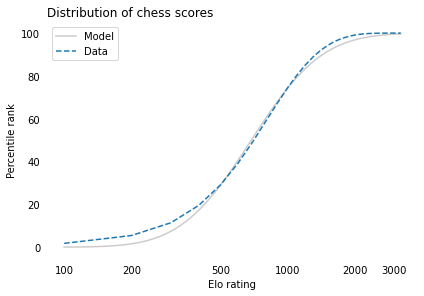

In [148]:
def plot_chess(pmf, mu, sigma):
    low, high = pmf.qs.min(), pmf.qs.max()
    qs = np.linspace(low, high)
    ps = norm.cdf(qs, mu, sigma) * 100
    Cdf(ps, qs).plot(color="gray", alpha=0.4, label="Model")
    (pmf.make_cdf() * 100).plot(ls="--", label="Data")

    decorate(xlabel="Elo rating", ylabel="Percentile rank")


plot_chess(pmf_log_chess, mu, sigma)
plt.title("Distribution of chess scores")
labels = [100, 200, 500, 1000, 2000, 3000]
xlabels(labels)

The lognormal model does not fit the data particularly well.
But that might be misleading, because unlike running speeds, Elo scores have no natural zero point.
The conventional zero point was chosen arbitrarily, which means we can shift it up or down without changing what the scores mean relative to each other.

With that in mind, suppose we shift the entire scale so that the lowest point is 550 rather than 100.
The following figure shows the distribution of these shifted scores on a log scale, along with a lognormal model.

In [149]:
pmf_chess2 = Pmf(pmf_chess.ps, pmf_chess.qs + 450)

In [150]:
pmf_log_chess2 = pmf_chess2.transform(np.log10)
cdf_log_chess2 = pmf_log_chess2.make_cdf()

In [151]:
x0 = pmf_log_chess2.mean(), pmf_log_chess2.std()
x0

(3.0789722328987064, 0.1422676157538474)

In [152]:
mu, sigma = fit_model_to_cdf(cdf_log_chess2, x0)

[3.07897223 0.14226762]
[3.07897228 0.14226762]
[3.07897223 0.14226763]
[3.06208626 0.15169365]
[3.06208631 0.15169365]
[3.06208626 0.15169366]


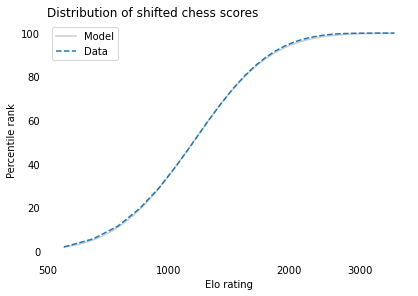

In [153]:
plot_chess(pmf_log_chess2, mu, sigma)
plt.title("Distribution of shifted chess scores")
labels = [500, 1000, 2000, 3000]
xlabels(labels)

With this adjustment, the lognormal model fits the data well.



## The Greatest of All Time

And more often than not, these top performers are not just a little better than the rest, they are a *lot* better.
To demonstrate this point, I generated a random sample of 100,000 people from a lognormal distribution loosely based on chess ratings.
Then I generated a sample from a Gaussian distribution with the same mean and variance.
The following figure shows the results.

In [154]:
def top_three(n, dist):
    """Compute the expected values of the top 3 in a given distribution.
    
    n: sample size
    dist: SciPy stats distribution object
    
    returns: array of three quantities
    """
    ps = 1 - np.array([3, 2, 1]) / n
    return dist.ppf(ps)

In [155]:
np.random.seed(19)
rvs = norm.rvs(2.1, 0.295, size=100000)
lognormal = np.power(10, rvs) + 500
mu, sigma = lognormal.mean(), lognormal.std()
mu, sigma

(658.7170292835305, 122.27837304897953)

In [156]:
lognormal.sort()
lognormal_top3 = lognormal[-3:].round().astype(int)
lognormal_top3

array([2913, 3066, 3155])

In [157]:
normal = norm.rvs(mu, sigma, size=100000)
normal.mean(), normal.std()

(658.2820476691168, 122.91277471624949)

In [158]:
normal.sort()
normal_top3 = normal[-3:].round().astype(int)
normal_top3

array([1123, 1146, 1161])

In [159]:
cdf_lognormal = Cdf.from_seq(lognormal) * 100
cdf_normal = Cdf.from_seq(normal) * 100

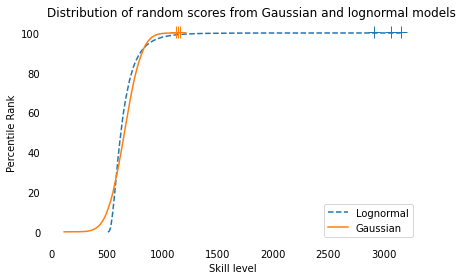

In [160]:
cdf_lognormal.plot(ls="--", label="Lognormal")
cdf_normal.plot(label="Gaussian")

for x in lognormal[-3:]:
    plt.plot(x, 100.3, "+", color="C0", ms=12)

for x in normal[-3:]:
    plt.plot(x, 100.3, "+", color="C1", ms=12)

decorate(
    xlabel="Skill level",
    ylabel="Percentile Rank",
    title="Distribution of random scores from Gaussian and lognormal models",
)

The crosses indicate the top three scorers in each sample.
In the Gaussian distribution, the top three scores are 1123, 1146, and 1161.
They are barely distinguishable in the figure, and and if we think of them as Elo scores, there is not much difference between them. According to the Elo formula, we expect the top player to beat the \#3 player about 55% of the time.

In the lognormal distribution, the top three scores are 2913, 3066, and 3155.
They are clearly distinct in the figure and substantially different in practice.
In this example, we expect the top player to beat \#3 about 80% of the time.

In [161]:
diff = normal_top3[2] - normal_top3[0]
diff, elo_prob(diff)

(38, 0.5544693740216761)

In [162]:
diff = lognormal_top3[2] - lognormal_top3[0]
diff, elo_prob(diff)

(242, 0.8010809398289456)

In reality, the top-rated chess players in the world are more tightly clustered than my simulated players.

In [163]:
elo_prob(2864 - 2799)

0.5924662305843318

## Sources and related reading

* The ANSUR-II dataset is available from the Open Design Lab at Penn State \cite{ansur2012}.

* Data from the Behavioral Risk Factor Surveillance System (BRFSS) data is available from the Centers for Disease Control and Prevention (CDC) \cite{brfss2020}.

*   The running speed data is originally from Cool Running, now available from the Internet Archive \cite{cool2010}.

* The chess data is from the Chess.com leaderboard \cite{chess2022}.


Probably Overthinking It

Copyright 2022 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).